In [1]:
import json
import struct
import numpy as np
import matplotlib.pyplot as plt
import photonforge as pf
import siepic_forge as siepic
import luxtelligence_lnoi400_forge as lxt
import tidy3d as td

td.config.logging_level = "ERROR"

# Set up technologies
siepic_tech = siepic.ebeam()
basic_tech = pf.basic_technology()
lxt_tech = lxt.lnoi400()
pf.config.default_technology = siepic_tech

# Initialize live viewer for real-time visualization
from photonforge.live_viewer import LiveViewer
viewer = LiveViewer()

# Define simulation parameters
wavelengths = np.linspace(1.53, 1.57, 101)
freqs = pf.C_0 / wavelengths

LiveViewer started at http://localhost:65229


In [2]:
dual_mode_spec = siepic_tech.ports["TE_1550_500"].copy()
dual_mode_spec.num_modes = 2  # Use both modes

siepic_tech.add_port("TE-TM_1550_500", dual_mode_spec)
siepic_tech.ports["TE-TM_1550_500"]

PortSpec(description="Strip TE 1550 nm, w=500 nm", width=2, limits=(-1, 1.22), num_modes=2, added_solver_modes=0, polarization="", target_neff=3.5, default_radius=0, path_profiles=[(0.5, 0, (1, 0))])

In [3]:
plasmonic_gold_layer = pf.LayerSpec(layer=(15, 0), description="Metal", color="F5BC00", pattern="xx")

siepic_tech.add_layer("Plasmonic Gold", plasmonic_gold_layer)

Name,Layer,Description,Color,Pattern
Si,"(1, 0)",Waveguides,#ff80a818,\\
PinRec,"(1, 10)",SiEPIC,#00408018,/
PinRecM,"(1, 11)",SiEPIC,#00408018,/
Si_Litho193nm,"(1, 69)",Waveguides,#cc80a818,\
Waveguide,"(1, 99)",Waveguides,#ff80a818,\
Si slab,"(2, 0)",Waveguides,#80a8ff18,/
SiN,"(4, 0)",Waveguides,#a6cee318,\\
Oxide open (to BOX),"(6, 0)",Waveguides,#ffae0018,\
Text,"(10, 0)",,#0000ff18,\
M1_heater,"(11, 0)",Metal,#ebc63418,xx


In [4]:
plasmonic_gold_gap = 0.03  # Gap between waveguide and gold
plasmonic_gold_thickness = 0.14  # Thickness of the gold layer
wg_height = 0.22

plasmonic_gold_extrusion = pf.ExtrusionSpec(mask_spec=pf.MaskSpec((15, 0)), 
                                            medium={"optical": td.material_library['Au']['JohnsonChristy1972'], 
                                                    "electrical": td.LossyMetalMedium(conductivity=17.0, fit_param={'attrs': {}, 'max_num_poles': 16, 'tolerance_rms': 0.001, 'frequency_sampling_points': 20, 'log_sampling': True, 'type': 'SurfaceImpedanceFitterParam'}, frequency_range=(100000000.0, 200000000000.0))}, 
                                                    limits=(wg_height+plasmonic_gold_gap, wg_height+plasmonic_gold_gap+plasmonic_gold_thickness), sidewall_angle=0, reference="top")
siepic_tech.insert_extrusion_spec(4, plasmonic_gold_extrusion)

Name,Layer,Description,Color,Pattern
Si,"(1, 0)",Waveguides,#ff80a818,\\
PinRec,"(1, 10)",SiEPIC,#00408018,/
PinRecM,"(1, 11)",SiEPIC,#00408018,/
Si_Litho193nm,"(1, 69)",Waveguides,#cc80a818,\
Waveguide,"(1, 99)",Waveguides,#ff80a818,\
Si slab,"(2, 0)",Waveguides,#80a8ff18,/
SiN,"(4, 0)",Waveguides,#a6cee318,\\
Oxide open (to BOX),"(6, 0)",Waveguides,#ffae0018,\
Text,"(10, 0)",,#0000ff18,\
M1_heater,"(11, 0)",Metal,#ebc63418,xx


In [5]:
class ThermalModel(pf.Model):
    def __init__(self, n_complex, voltage=0, coefficient=3e-4):
        super().__init__(
            n_complex=n_complex,
            voltage=voltage,
            coefficient=coefficient,
        )
        self.n_complex = np.array(n_complex, ndmin=2)
        self.voltage = voltage
        self.coefficient = coefficient

    def __copy__(self):
        return ThermalModel(self.n_complex, self.voltage, self.coefficient)

    def __deepcopy__(self, memo=None):
        # n_complex is an array, so we want to make sure to create a deep copy of it.
        # Other values (voltage and coefficient) are immutable (floats), so we can use them directly.
        return ThermalModel(self.n_complex.copy(), self.voltage, self.coefficient)

    def __repr__(self):
        return f"ThermalModel({self.n_complex!r}, {self.voltage!r}, {self.coefficient!r})"

    def __str__(self):
        return f"ThermalModel at {self.voltage} V"

    @property
    def as_bytes(self):
        coeffs = struct.pack("<2d", self.voltage, self.coefficient)
        shape = struct.pack("<2l", *self.n_complex.shape)
        n_data = self.n_complex.astype(complex).tobytes()
        # Add version 0 as first byte
        return b"\x00" + coeffs + shape + n_data

    @classmethod
    def from_bytes(cls, byte_repr):
        version = byte_repr[0]
        if version != 0:
            raise RuntimeError(f"Incompatible version for ThermalModel: {version}")

        byte_repr = byte_repr[1:]
        fmt = "<2d2l"
        head_len = struct.calcsize(fmt)
        voltage, coefficient, rows, cols = struct.unpack(fmt, byte_repr[:head_len])

        byte_repr = byte_repr[head_len:]
        n_complex = np.frombuffer(byte_repr, dtype=complex).reshape((rows, cols))

        return cls(n_complex, voltage, coefficient)

    @pf.cache_s_matrix
    def start(self, component, frequencies, voltage=None, **kwargs):
        # Allow overriding voltage as an `s_matrix` kwarg too
        if voltage is None:
            voltage = self.voltage
        n_complex = self.n_complex + self.coefficient * voltage**2
        wg_model = pf.WaveguideModel(n_complex)
        return wg_model.start(component, frequencies, **kwargs)


pf.register_model_class(ThermalModel)

In [6]:
@pf.parametric_component
def create_mzm(*, name, port_spec="TE_1550_500", coupling_distance=0.6, coupling_length=5.35, ps_length=100):

    # Bend and Straight waveguide to form the microring
    phase_shifter = pf.parametric.straight(name=f"ps", port_spec=port_spec, length=ps_length)
    straight = pf.parametric.straight(port_spec=port_spec, length=ps_length)
    bend = pf.parametric.bend(port_spec=port_spec, radius=5)
    coupler = pf.parametric.dual_ring_coupler(
        port_spec=port_spec, coupling_distance=coupling_distance, coupling_length=coupling_length, radius=5, 
        tidy3d_model_kwargs={
            # These symmetries are not correct for arbitrary ports.
            # They can be used in this case for the fundamental mode.
            "port_symmetries": [
                ("P1", "P0", "P3", "P2"),
                ("P2", "P3", "P0", "P1"),
                ("P3", "P2", "P1", "P0"),
            ],
        },
    )

    # Solve for the port mode of the waveguide and extract the complex refractive index
    alpha = 10
    kappa = (alpha * wavelengths * 1e-4 * np.log(10)) / (40 * np.pi)
    mode_solver = pf.port_modes(port=phase_shifter.ports["P0"], frequencies=freqs)
    n_complex = mode_solver.data.n_complex.values.T + 1j * kappa  # add propagation loss

    thermal_model = ThermalModel(n_complex=n_complex)
    phase_shifter.add_model(thermal_model, "Thermal")

    mzm = pf.Component(name)

    # form main microring structure
    cp1_ref = mzm.add_reference(coupler)
    cp2_ref = mzm.add_reference(coupler)
    ps1_ref = mzm.add_reference(phase_shifter)
    bend1_ref = mzm.add_reference(bend)
    bend2_ref = mzm.add_reference(bend) 
    bend3_ref = mzm.add_reference(bend)
    bend4_ref = mzm.add_reference(bend) 
    str1_ref = mzm.add_reference(straight)

    #Coupler Kiri
    bend1_ref.connect("P1", cp1_ref["P3"])
    bend2_ref.connect("P0", cp1_ref["P2"])
    #Tengah
    # trans1_ref.connect("P0", bend1_ref["P0"])
    ps1_ref.connect("P0", bend1_ref["P0"])
    str1_ref.connect("P0", bend2_ref["P1"])

    # trans2_ref.connect("P1", ps1_ref["P1"])
    bend3_ref.connect("P1", ps1_ref["P1"])
    bend4_ref.connect("P0", str1_ref["P1"])
    #Coupler Kanan
    cp2_ref.connect("P1", bend3_ref["P0"])
    cp2_ref.connect("P0", bend4_ref["P1"])


    # Define the heater and electrical path
    terminal_width = 10
    heater_width = 2

    heater = (
        pf.Path((ps1_ref.x_min, ps1_ref.y_mid), heater_width)
        .segment((ps1_ref.x_max, ps1_ref.y_mid), heater_width)
    )

    route_vp = (
        pf.Path((cp1_ref.x_mid-terminal_width/2, ps1_ref.y_mid), terminal_width)
        .segment((cp1_ref.x_mid+terminal_width/2, ps1_ref.y_mid), terminal_width)
        .segment((ps1_ref.x_min, ps1_ref.y_mid), heater_width)
    )

    route_vn = (
        pf.Path((ps1_ref.x_max, ps1_ref.y_mid), heater_width)
        .segment((cp2_ref.x_mid-terminal_width/2, ps1_ref.y_mid), terminal_width)
        .segment((cp2_ref.x_mid+terminal_width/2, ps1_ref.y_mid), terminal_width)
    )

    mzm.add((11,0), heater)
    mzm.add((12,0), route_vp)
    mzm.add((12,0), route_vn)
    mzm.add_terminal(pf.Terminal((12,0), pf.Rectangle(size=(terminal_width, terminal_width), center=(cp1_ref.x_mid, ps1_ref.y_mid))), "VP")
    mzm.add_terminal(pf.Terminal((12,0), pf.Rectangle(size=(terminal_width, terminal_width), center=(cp2_ref.x_mid, ps1_ref.y_mid))), "VN")

    ## COMPONENT MODELS
    mzm.add_port(mzm.detect_ports([port_spec]))
    mzm.add_model(pf.CircuitModel(), "CircuitModel")

    port_symmetries = [
        ("P1", "P0", "P3", "P2"),
        ("P2", "P3", "P0", "P1"),
        ("P3", "P2", "P1", "P0"),
    ]

    field_monitor = td.FieldMonitor(
        center=(0, 0, 0.11), size=(td.inf, td.inf, 0), freqs=[freqs.mean()], name="field"
    )

    # mzm.add_model(pf.Tidy3DModel(port_symmetries=port_symmetries, monitors=[field_monitor]), "Tidy3DModel")

    return mzm

# mzm = create_mzm(name="mzm", port_spec="TE-TM_1550_500", coupling_length=4.3)
# viewer(mzm)

In [7]:
@pf.parametric_component
def create_hybrid_rotator(*, gold_length=4.25, gold_width=0.252, gold_location="Left"):

    wg_length = 8.5
    wg_height = 0.22
    wg_width = 0.5

    # Create an empty component named "HybridRotator"
    hybrid_rotator = pf.Component("HybridRotator")

    waveguide = pf.Rectangle(size=(wg_length, wg_width))
    gold_plate = pf.Rectangle(size=(gold_length, gold_width), center=(0, (-1 if gold_location == "Right" else 1)*(wg_width/2-gold_width/2)))

    # Add the geometry to the "Si" and "Plasmonic Gold" layers
    hybrid_rotator.add("Si", waveguide)
    hybrid_rotator.add("Plasmonic Gold", gold_plate)

    hybrid_rotator.add_port(
        pf.Port(center=(-wg_length/2, 0), input_direction=0, spec=siepic_tech.ports["TE_1550_500"])
    )

    hybrid_rotator.add_port(
        pf.Port(center=(wg_length/2, 0), input_direction=180, spec=siepic_tech.ports["TE-TM_1550_500"])
    )

    field_monitor = td.FieldMonitor(
        center=(0, 0, 0.11), size=(td.inf, td.inf, 0), freqs=[freqs.mean()], name="field"
    )

    input_monitor = td.FieldMonitor(
        center=[-wg_length/2, 0.0, wg_height / 2],
        size=[0.0, wg_width * 3, wg_height * 3],
        freqs=freqs,
        name="input",
        fields=["Ex", "Ey", "Ez", "Hx", "Hy", "Hz"]
    )

    output_monitor = td.FieldMonitor(
        center=[wg_length/2, 0.0, wg_height / 2],
        size=[0.0, wg_width * 3, wg_height * 3],
        freqs=freqs,
        name="output",
        fields=["Ex", "Ey", "Ez", "Hx", "Hy", "Hz"]
    )

    # Include the Tidy3D simulation model
    hybrid_rotator.add_model(pf.Tidy3DModel(monitors=[field_monitor, input_monitor, output_monitor]), "Tidy3DModel")
    return hybrid_rotator


# Instantiate the component with custom dimensions
# hybrid_rotator = create_hybrid_rotator(gold_location="Right")
# viewer(hybrid_rotator)

In [10]:
# COMPONENTS DEFINITION

alice_top = pf.Component("alice_top")

straight = pf.parametric.straight(port_spec="TE_1550_500", length=130.7)
straight_mirror = pf.parametric.straight(port_spec="TE-TM_1550_500", length=128.6)
half_straight = pf.parametric.straight(port_spec="TE_1550_500", length=50)
half_straight_mirror = pf.parametric.straight(port_spec="TE-TM_1550_500", length=50)
quarter_straight = pf.parametric.straight(port_spec="TE_1550_500", length=10)
quarter_straight_mirror = pf.parametric.straight(port_spec="TE-TM_1550_500", length=10)
bend = pf.parametric.bend(port_spec="TE_1550_500", radius=5, euler_fraction=0.5, angle=90)
bend_mirror = pf.parametric.bend(port_spec="TE-TM_1550_500", radius=5, euler_fraction=0.5, angle=90)

grating_coupler = siepic.component("ebeam_gc_te1550")

mzm_base = create_mzm(name="mzm_base", port_spec="TE_1550_500", coupling_length=5.35)
mzm_bit = create_mzm(name="mzm_bit", port_spec="TE_1550_500", coupling_length=5.35)
mzm_base_mirror = create_mzm(name="mzm_base_mirror", port_spec="TE-TM_1550_500", coupling_length=4.3)
mzm_bit_mirror = create_mzm(name="mzm_bit_mirror", port_spec="TE-TM_1550_500", coupling_length=4.3)

rotator_45 = create_hybrid_rotator(gold_location="Left")
rotator_n45 = create_hybrid_rotator(gold_location="Right")
rotator_0 = pf.parametric.transition(port_spec1="TE_1550_500", port_spec2="TE-TM_1550_500", length=8.5)


# COMPONENTS REFERENCES

gc1_ref = alice_top.add_reference(grating_coupler)
gc2_ref = alice_top.add_reference(grating_coupler)

MZM1_ref = alice_top.add_reference(mzm_base)
MZM2_ref = alice_top.add_reference(mzm_bit)
MZM3_ref = alice_top.add_reference(mzm_bit)
MZM4_ref = alice_top.add_reference(mzm_bit_mirror)
MZM5_ref = alice_top.add_reference(mzm_bit_mirror)
MZM6_ref = alice_top.add_reference(mzm_base_mirror)

rot1_ref = alice_top.add_reference(rotator_n45)
rot2_ref = alice_top.add_reference(rotator_45)
rot3_ref = alice_top.add_reference(rotator_0)
rot4_ref = alice_top.add_reference(rotator_0)

st1_ref = alice_top.add_reference(straight)
st2_ref = alice_top.add_reference(straight)
st3_ref = alice_top.add_reference(straight_mirror)
st4_ref = alice_top.add_reference(straight_mirror)
# st5_ref = alice_top.add_reference(straight)
# st6_ref = alice_top.add_reference(straight)
# st7_ref = alice_top.add_reference(straight)
# st8_ref = alice_top.add_reference(straight)

hst1_ref = alice_top.add_reference(half_straight)
hst2_ref = alice_top.add_reference(half_straight_mirror)
# hst3_ref = alice_top.add_reference(half_straight)
# hst4_ref = alice_top.add_reference(half_straight)
# hst5_ref = alice_top.add_reference(half_straight)
# hst6_ref = alice_top.add_reference(half_straight)
# hst7_ref = alice_top.add_reference(half_straight)
# hst8_ref = alice_top.add_reference(half_straight)
# hst9_ref = alice_top.add_reference(half_straight)   

qst1_ref = alice_top.add_reference(quarter_straight)
qst2_ref = alice_top.add_reference(quarter_straight)
qst3_ref = alice_top.add_reference(quarter_straight)
qst4_ref = alice_top.add_reference(quarter_straight)
qst5_ref = alice_top.add_reference(quarter_straight_mirror)
qst6_ref = alice_top.add_reference(quarter_straight_mirror)
qst7_ref = alice_top.add_reference(quarter_straight_mirror)
qst8_ref = alice_top.add_reference(quarter_straight_mirror)
# qst9_ref = alice_top.add_reference(quarter_straight)
# qst10_ref = alice_top.add_reference(quarter_straight)
# qst11_ref = alice_top.add_reference(quarter_straight)
# qst12_ref = alice_top.add_reference(quarter_straight)
# qst13_ref = alice_top.add_reference(quarter_straight)

bend1_ref = alice_top.add_reference(bend)
bend2_ref = alice_top.add_reference(bend)
bend3_ref = alice_top.add_reference(bend)
bend4_ref = alice_top.add_reference(bend)
bend5_ref = alice_top.add_reference(bend)
bend6_ref = alice_top.add_reference(bend)
bend7_ref = alice_top.add_reference(bend)
bend8_ref = alice_top.add_reference(bend)   
bend9_ref = alice_top.add_reference(bend)
bend10_ref = alice_top.add_reference(bend_mirror)
bend11_ref = alice_top.add_reference(bend_mirror)
bend12_ref = alice_top.add_reference(bend_mirror)
bend13_ref = alice_top.add_reference(bend_mirror)
bend14_ref = alice_top.add_reference(bend_mirror)
bend15_ref = alice_top.add_reference(bend_mirror)
bend16_ref = alice_top.add_reference(bend_mirror)
bend17_ref = alice_top.add_reference(bend_mirror)
bend18_ref = alice_top.add_reference(bend_mirror)


# COMPONENTS CONNECTIONS

# DECISION REGION
#Grating Coupler Input, MZM 1
hst1_ref.connect("P0",gc1_ref["P0"])

#MZM 1 base middle
bend1_ref.connect("P1",hst1_ref["P1"])
MZM1_ref.connect("P1",bend1_ref["P0"])

#MZM 2 (atas)
qst1_ref.connect("P0",MZM1_ref["P3"])
bend2_ref.connect("P0",qst1_ref["P1"])
st1_ref.connect("P1",bend2_ref["P1"])
bend3_ref.connect("P1",st1_ref["P0"]) 
qst2_ref.connect("P0",bend3_ref["P0"])
MZM2_ref.connect("P0",qst2_ref["P1"])

#MZM 3 (bawah)
qst3_ref.connect("P0",MZM1_ref["P2"])
bend4_ref.connect("P1",qst3_ref["P1"])
st2_ref.connect("P1",bend4_ref["P0"])
bend5_ref.connect("P0",st2_ref["P0"])
qst4_ref.connect("P1",bend5_ref["P1"])
MZM3_ref.connect("P1",qst4_ref["P0"])

# ROTATOR REGION
#Rotator 90
bend6_ref.connect("P1",MZM2_ref["P3"])
rot1_ref.connect("P0",bend6_ref["P0"])

#Rotator 0
bend7_ref.connect("P0",MZM2_ref["P2"])
rot2_ref.connect("P0",bend7_ref["P1"])

#Rotator -45
bend8_ref.connect("P1",MZM3_ref["P3"])
rot3_ref.connect("P0",bend8_ref["P0"])

#Rotator 45
bend9_ref.connect("P0",MZM3_ref["P2"])
rot4_ref.connect("P0",bend9_ref["P1"])

# MIRROR REGION
#MZM 4 bit top
bend10_ref.connect("P1",rot1_ref["P1"])
bend11_ref.connect("P0",rot2_ref["P1"])
MZM4_ref.connect("P0",bend11_ref["P1"])

#MZM 5 bit bottom
bend12_ref.connect("P1",rot3_ref["P1"])
bend13_ref.connect("P0",rot4_ref["P1"])
MZM5_ref.connect("P0",bend13_ref["P1"])

#MZM 6 base middle
qst5_ref.connect("P0",MZM4_ref["P2"])
bend14_ref.connect("P1",qst5_ref["P1"])
st3_ref.connect("P1",bend14_ref["P0"])
bend15_ref.connect("P0",st3_ref["P0"])
qst6_ref.connect("P1",bend15_ref["P1"])

qst7_ref.connect("P0",MZM5_ref["P3"])
bend16_ref.connect("P0",qst7_ref["P1"])
st4_ref.connect("P1",bend16_ref["P1"])
bend17_ref.connect("P1",st4_ref["P0"])
qst8_ref.connect("P1",bend17_ref["P0"])

MZM6_ref.connect("P0",qst8_ref["P0"])
bend18_ref.connect("P1",MZM6_ref["P3"])

hst2_ref.connect("P0",bend18_ref["P0"])
gc2_ref.connect("P0",hst2_ref["P1"])


#ELECTRICAL CONNECTIONS
terminal_width = 15

# Terminals
alice_top.add_terminal(pf.Terminal((12,0), pf.Rectangle(size=(terminal_width, terminal_width), 
                                                        center=(MZM2_ref.x_min + terminal_width/2 + 0.425, MZM2_ref.y_max + terminal_width/2 + 10))), 
                       "GND1", add_structure=True)

alice_top.add_terminal(pf.Terminal((12,0), pf.Rectangle(size=(terminal_width, terminal_width), 
                                                        center=(MZM4_ref.x_max - terminal_width/2 - 0.425, MZM2_ref.y_max + terminal_width/2 + 10))), 
                       "GND2", add_structure=True)

alice_top.add_terminal(pf.Terminal((12,0), pf.Rectangle(size=(terminal_width, terminal_width), 
                                                        center=(rot1_ref.x_mid, MZM2_ref.y_max + terminal_width/2 + 10))), 
                       "V_BIT", add_structure=True)

alice_top.add_terminal(pf.Terminal((12,0), pf.Rectangle(size=(terminal_width, terminal_width), 
                                                        center=(rot4_ref.x_mid, rot4_ref.y_min - terminal_width/2 - 15))), 
                       "V_BASE", add_structure=True)

pads = alice_top.terminals

# Electrical routing

# V_BIT
alice_top.add(
    pf.parametric.route_manhattan(
        terminal1=pads["V_BIT"],
        terminal2=(MZM2_ref, "VN", 0),
        direction1="y",
        direction2="y",
        width=10
    ),
    pf.parametric.route_manhattan(
        terminal1=pads["V_BIT"],
        terminal2=(MZM3_ref, "VN", 0),
        direction1="y",
        direction2="y",
        width=10
    ),
    pf.parametric.route_manhattan(
        terminal1=pads["V_BIT"],
        terminal2=(MZM4_ref, "VP", 0),
        direction1="y",
        direction2="y",
        width=10
    ),
    pf.parametric.route_manhattan(
        terminal1=pads["V_BIT"],
        terminal2=(MZM5_ref, "VP", 0),
        direction1="y",
        direction2="y",
        width=10
    ),
)

# V_BASE
alice_top.add(
    pf.parametric.route_manhattan(
        terminal1=(MZM1_ref, "VP", 0),
        terminal2=pads["V_BASE"],
        direction1="x",
        direction2="y",
        width=10,
        waypoints=[(MZM1_ref.x_min + terminal_width/2 + 0.425 - 20, MZM1_ref.y_max), 
                   (MZM1_ref.x_min + terminal_width/2 + 0.425 - 20, MZM3_ref.y_min),
                   (rot4_ref.x_mid, rot4_ref.y_min),
                   ]
    ),
    pf.parametric.route_manhattan(
        terminal1=(MZM6_ref, "VN", 0),
        terminal2=pads["V_BASE"],
        direction1="x",
        direction2="y",
        width=10,
        waypoints=[(MZM6_ref.x_max - terminal_width/2 - 0.425 + 20, MZM6_ref.y_max), 
                   (MZM6_ref.x_max - terminal_width/2 - 0.425 + 20, MZM5_ref.y_min),
                   (rot4_ref.x_mid, rot4_ref.y_min),
                   ]
    )
)

# GND
alice_top.add(
    pf.parametric.route_manhattan(
        terminal1=pads["GND1"],
        terminal2=(MZM3_ref, "VP", 0),
        direction1="y",
        direction2="y",
        width=10,
        waypoints=[(MZM2_ref.x_min + terminal_width/2 + 0.425, MZM2_ref.y_min), 
                   (MZM2_ref.x_max - terminal_width/2 - 0.425, MZM2_ref.y_min),
                   (MZM1_ref.x_max - terminal_width/2 - 0.425, MZM1_ref.y_min),
                   (MZM1_ref.x_min + terminal_width/2 + 0.425, MZM1_ref.y_min), 
                   ]
    ),
    pf.parametric.route_manhattan(
        terminal1=pads["GND2"],
        terminal2=(MZM5_ref, "VN", 0),
        direction1="y",
        direction2="y",
        width=10,
        waypoints=[(MZM4_ref.x_max - terminal_width/2 - 0.425, MZM4_ref.y_min), 
                   (MZM4_ref.x_min + terminal_width/2 + 0.425, MZM4_ref.y_min),
                   (MZM6_ref.x_min + terminal_width/2 + 0.425, MZM6_ref.y_min),
                   (MZM6_ref.x_max - terminal_width/2 - 0.425, MZM6_ref.y_min), 
                   ]
    ),
)

alice_top.add_port(alice_top.detect_ports(["TE_1550_500"], on_boundary="x"))
alice_top.add_model(pf.CircuitModel(), "CircuitModel")
alice_top.add_model(pf.Tidy3DModel(), "Tidy3D")

viewer(alice_top)

Progress: 100% 
Progress: 100% 
Progress: 100% 
Progress: 100% 


c:\Users\irfan\AppData\Local\Programs\Python\Python313\Lib\site-packages\photonforge\parametric_utils.py:168: RuntimeWarning: Skipped point (42.675, 5) from route
  c = component_func(*args, **kwargs)
c:\Users\irfan\AppData\Local\Programs\Python\Python313\Lib\site-packages\photonforge\parametric_utils.py:168: RuntimeWarning: Skipped point (365.125, 5) from route
  c = component_func(*args, **kwargs)


In [11]:
pf.tidy3d_plot(alice_top, plot_type="3d")

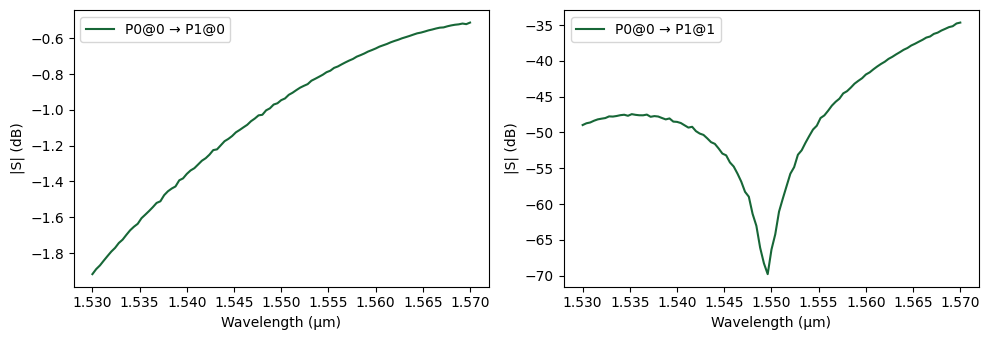

In [11]:
s_matrix = alice_top.s_matrix(freqs, model_kwargs={"inputs": ["P0"]})
fig, ax = pf.plot_s_matrix(s_matrix, input_ports=["P0"], output_ports=["P1", "P2", "P3", "P4"], y="dB")

c:\Users\irfan\AppData\Local\Programs\Python\Python313\Lib\site-packages\photonforge\circuit_base.py:211: RuntimeWarning: Terminal 'VN' at (125.35, 5) from component 'mzm_base' does not match any reference terminals and will be ignored.
  netlist = component.get_netlist()
c:\Users\irfan\AppData\Local\Programs\Python\Python313\Lib\site-packages\photonforge\circuit_base.py:211: RuntimeWarning: Terminal 'VP' at (0, 5) from component 'mzm_base' does not match any reference terminals and will be ignored.
  netlist = component.get_netlist()
c:\Users\irfan\AppData\Local\Programs\Python\Python313\Lib\site-packages\photonforge\circuit_base.py:211: RuntimeWarning: Terminal 'VN' at (125.35, 5) from component 'mzm_bit' does not match any reference terminals and will be ignored.
  netlist = component.get_netlist()
c:\Users\irfan\AppData\Local\Programs\Python\Python313\Lib\site-packages\photonforge\circuit_base.py:211: RuntimeWarning: Terminal 'VP' at (0, 5) from component 'mzm_bit' does not match a

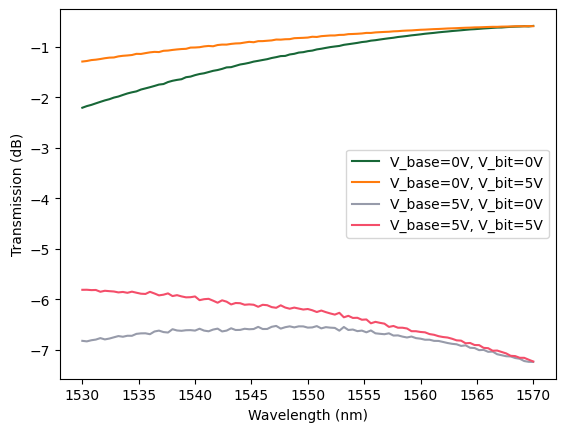

In [12]:
voltages = [0, 5]  # first is LOW voltage, second is HIGH voltage

fig, axs = plt.subplots()

for i in range(2):
    for j in range(2):
        updates = {("mzm_base", 0, "ps", 0): {"model_updates": {"voltage": voltages[i]}},
                    ("mzm_bit", 0, "ps", 0): {"model_updates": {"voltage": voltages[j]}},
                    ("mzm_bit", 1, "ps", 0): {"model_updates": {"voltage": voltages[j]}},
                    ("mzm_base_mirror", 0, "ps", 0): {"model_updates": {"voltage": voltages[i]}},
                    ("mzm_bit_mirror", 0, "ps", 0): {"model_updates": {"voltage": voltages[j]}},
                    ("mzm_bit_mirror", 1, "ps", 0): {"model_updates": {"voltage": voltages[j]}},
                  }
        s_matrix = alice_top.s_matrix(freqs, model_kwargs={"updates": updates, "inputs": ["P0@0"]})
        s1 = s_matrix[("P0@0", "P1@0")]
        axs.plot(
            wavelengths * 1e3,
            10*np.log(np.abs(s1)),
            label=f"V_base={voltages[i]}V, V_bit={voltages[j]}V",
            linewidth=1.5,
        )

axs.set_xlabel("Wavelength (nm)")
axs.set_ylabel("Transmission (dB)")
axs.legend()

plt.show()


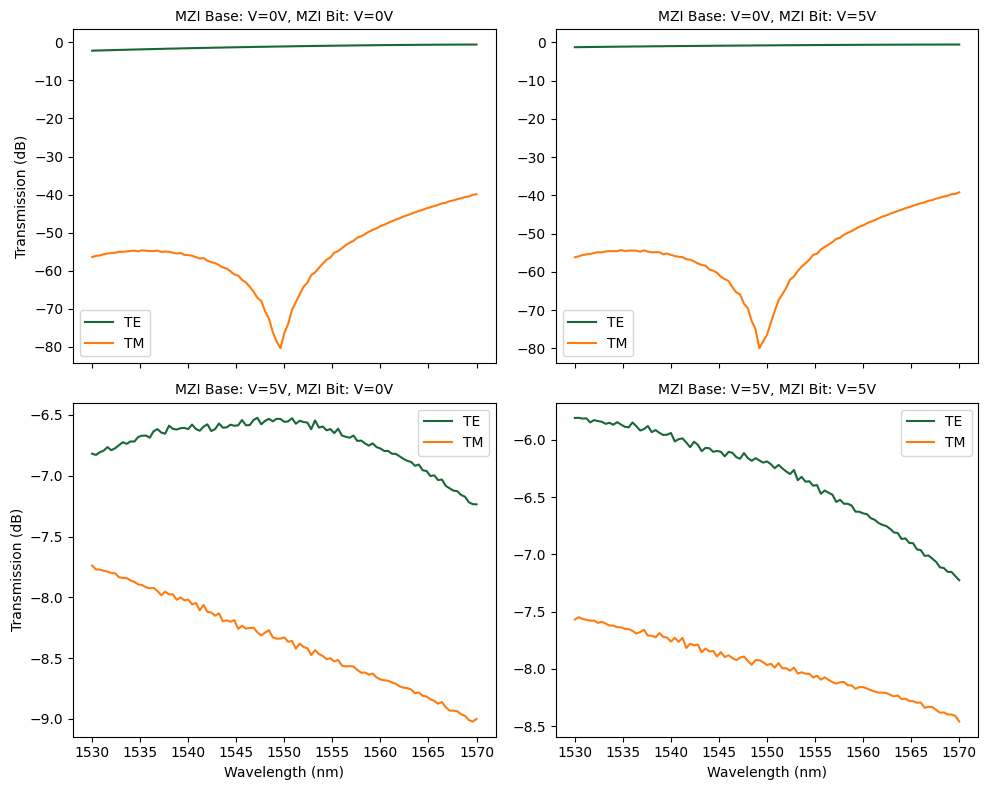

In [18]:
voltages = [0, 5]  # first is LOW voltage, second is HIGH voltage

# make one figure/axes
fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=False, figsize=(10, 8))

for i in range(2):
    for j in range(2):
        updates = {("mzm_base", 0, "ps", 0): {"model_updates": {"voltage": voltages[i]}},
                    ("mzm_bit", 0, "ps", 0): {"model_updates": {"voltage": voltages[j]}},
                    ("mzm_bit", 1, "ps", 0): {"model_updates": {"voltage": voltages[j]}},
                    ("mzm_base_mirror", 0, "ps", 0): {"model_updates": {"voltage": voltages[i]}},
                    ("mzm_bit_mirror", 0, "ps", 0): {"model_updates": {"voltage": voltages[j]}},
                    ("mzm_bit_mirror", 1, "ps", 0): {"model_updates": {"voltage": voltages[j]}},
                  }
        s_matrix = alice_top.s_matrix(freqs, model_kwargs={"updates": updates, "inputs": ["P0"]})
        axs[i][j].set_title(f"MZI Base: V={voltages[i]}V, MZI Bit: V={voltages[j]}V", fontsize=10)
        s0 = s_matrix[("P0@0", "P1@0")]
        s1 = s_matrix[("P0@0", "P1@1")]
        axs[i][j].plot(
            wavelengths * 1e3,
            10*np.log(np.abs(s0)),
            label=f"TE",
            linewidth=1.5,
        )
        axs[i][j].plot(
            wavelengths * 1e3,
            10*np.log(np.abs(s1)),
            label=f"TM",
            linewidth=1.5,
        )
        axs[i][j].legend()

# labels & legend
axs[1][0].set_xlabel("Wavelength (nm)")
axs[1][1].set_xlabel("Wavelength (nm)")
axs[0][0].set_ylabel("Transmission (dB)")
axs[1][0].set_ylabel("Transmission (dB)")

plt.tight_layout()
plt.show()

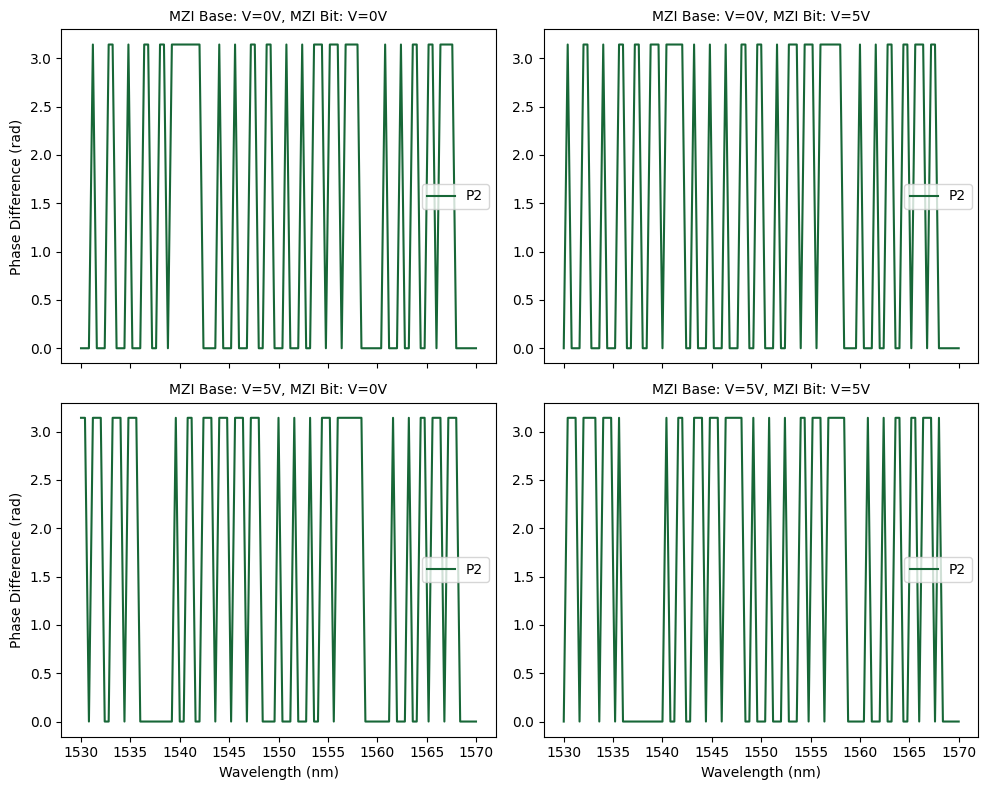

In [19]:
voltages = [0, 5]  # first is LOW voltage, second is HIGH voltage

# make one figure/axes
fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=False, figsize=(10, 8))

for i in range(2):
    for j in range(2):
        updates = {("mzm_base", 0, "ps", 0): {"model_updates": {"voltage": voltages[i]}},
                    ("mzm_bit", 0, "ps", 0): {"model_updates": {"voltage": voltages[j]}},
                    ("mzm_bit", 1, "ps", 0): {"model_updates": {"voltage": voltages[j]}},
                    ("mzm_base_mirror", 0, "ps", 0): {"model_updates": {"voltage": voltages[i]}},
                    ("mzm_bit_mirror", 0, "ps", 0): {"model_updates": {"voltage": voltages[j]}},
                    ("mzm_bit_mirror", 1, "ps", 0): {"model_updates": {"voltage": voltages[j]}},
                  }
        s_matrix = alice_top.s_matrix(freqs, model_kwargs={"updates": updates, "inputs": ["P0"]})
        axs[i][j].set_title(f"MZI Base: V={voltages[i]}V, MZI Bit: V={voltages[j]}V", fontsize=10)
        phase0 = np.angle(s_matrix[("P0@0", "P1@0")])
        phase1 = np.angle(s_matrix[("P0@0", "P1@1")])
        delta = phase1 - phase0
        axs[i][j].plot(
            wavelengths * 1e3,
            np.angle(delta),
            label=f"P2",
            linewidth=1.5,
        )
        axs[i][j].legend()

# labels & legend
axs[1][0].set_xlabel("Wavelength (nm)")
axs[1][1].set_xlabel("Wavelength (nm)")
axs[0][0].set_ylabel("Phase Difference (rad)")
axs[1][0].set_ylabel("Phase Difference (rad)")

plt.tight_layout()
plt.show()

In [ ]:
voltages = [0, 5]  # first is LOW voltage, second is HIGH voltage

# make one figure/axes
fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(10, 8))

for i in range(2):
    for j in range(2):
        updates = {("mzm_base", 0, "ps", 0): {"model_updates": {"voltage": voltages[i]}},
                    ("mzm_bit", 0, "ps", 0): {"model_updates": {"voltage": voltages[j]}},
                    ("mzm_bit", 1, "ps", 0): {"model_updates": {"voltage": voltages[j]}},          
                  }
        s_matrix = alice_top.s_matrix(freqs, model_kwargs={"updates": updates, "inputs": ["P0@0"]})
        axs[i][j].set_title(f"MZI Base: V={voltages[i]}V, MZI Bit: V={voltages[j]}V", fontsize=10)
        s1 = s_matrix[("P0@0", "P1@0")]
        s2 = s_matrix[("P0@0", "P2@0")]
        s3 = s_matrix[("P0@0", "P3@0")]
        s4 = s_matrix[("P0@0", "P4@0")]
        axs[i][j].plot(
            wavelengths * 1e3,
            10*np.log(np.abs(s1)),
            label=f"P1",
            linewidth=1.5,
        )
        axs[i][j].plot(
            wavelengths * 1e3,
            10*np.log(np.abs(s2)),
            label=f"P2",
            linewidth=1.5,
        )
        axs[i][j].plot(
            wavelengths * 1e3,
            10*np.log(np.abs(s3)),
            label=f"P3",
            linewidth=1.5,
        )
        axs[i][j].plot(
            wavelengths * 1e3,
            10*np.log(np.abs(s4)),
            label=f"P4",
            linewidth=1.5,
        )
        axs[i][j].legend()

# labels & legend
axs[1][0].set_xlabel("Wavelength (nm)")
axs[1][1].set_xlabel("Wavelength (nm)")
axs[0][0].set_ylabel("Transmission (dB)")
axs[1][0].set_ylabel("Transmission (dB)")

plt.tight_layout()
plt.show()